# Project 2: Continuous Control

The code is structured in the next way:
- Continuous_Control.ipynb: Main function. Just need to run one cell for training or another one for testing with the train model.
- DDPGAgent.py: Contains the implementation of the respective agent with modifications from the paper.
- models.py: COntains neural network architectures for actor and critic.

Run the next cell to perform the training. Go to the next cell if model import and testing is desired.

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Size of each action: 4
Episode 100	Average Score: 4.40	last score: 10.42
Episode 191	Average Score: 30.04	last score: 36.87
Environment solved in 91 episodes!	Average Score: 30.04


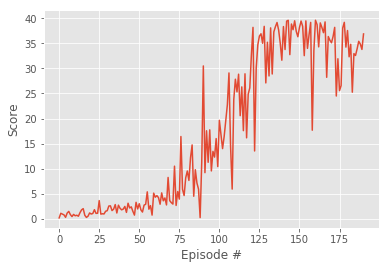

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import torch
from collections import deque
from DDPGAgent import Agent

count = 0
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]



# Create an agent, pass a desired size for the hiden layers.
agent = Agent(state_size=33, action_size=4, seed=10, gamma=0.99, tau=1e-3, 
              add_noise=True, mu=0, theta=0.15, sigma=0.1, 
              lr_actor=2e-4, lr_critic=2e-4,buffer_size=1e5, batch_size=128)


# Define dqn algorithm
def ddpg(n_episodes=500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start  # initialize epsilon
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        while True:
            action = agent.act(env_info.vector_observations, random=False)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]

            #next_state = agent.state_normalizer(next_state)
            #reward = agent.reward_normalizer(reward)

            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}\tlast score: {:.2f}'.format(i_episode, np.mean(scores_window), score), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}\tlast score: {:.2f}'.format(i_episode, np.mean(scores_window), score), end="")
        if np.mean(scores_window) >= 30.0 and i_episode > 50:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.critic.state_dict(), 'my_critic.pth')
            torch.save(agent.actor.state_dict(), 'my_actor.pth')
            break
        # A small step in learning rate to allow for quicker convergence with above set parameters
        #if i_episode == 1200:
        #    agent.adjust_learning_rate(1200, 2E-5)
    return scores


scores = ddpg()

env.close()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# Save scores
with open('scores.txt', 'w') as f:
    for item in scores:
        f.write("%f\n" % item)





## Loading score history only

Notice that the scores were saved in score.txt. They can be imported as seen in the next cell. We also print here a simple graph with the scores. The algorithm could solve the agent-environment interaction after 1194 episodes, but in reality we observed potential to grow further. See the README section to get to know more.

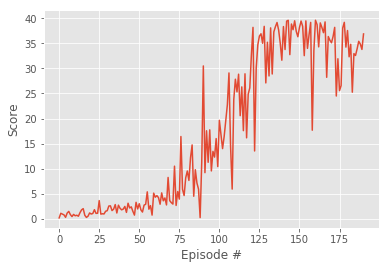

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')
# plot the scores
i_scores = []
with open('scores.txt', 'r') as f:  
    for line in f:
        # remove linebreak which is the last character of the string
        val = line[:-1]
        # add item to the list
        i_scores.append(float(val))
       
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(i_scores)), i_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


## Loading pretrained model and testing only

Run the next cell for testing only. Notice that we are re loading the environment, this time the version with visual interface attached. Also our pretrained model is being loaded into an agent instance and used for the loop.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from DDPGAgent import Agent

a_ch = torch.load('my_actor.pth')
c_ch = torch.load('my_critic.pth')
agent = Agent(state_size=33, action_size=4, seed=0, add_noise=True, a_check=a_ch, c_check=c_ch)

env = UnityEnvironment(file_name='Reacher_Linux/Reacher.x86_64')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]  # reset the environment
scores = 0
while True:
    action = agent.act(env_info.vector_observations, random=False)  # select an action (for each agent)
    actions = np.clip(action, -1, 1)  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]  # send all actions to tne environment
    next_states = env_info.vector_observations  # get next state (for each agent)
    rewards = env_info.rewards  # get reward (for each agent)
    dones = env_info.local_done  # see if episode finished
    scores += env_info.rewards[0]  # update the score (for each agent)
    states = next_states  # roll over states to next time step
    if np.any(dones) or scores > 10:  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Total score (averaged over agents) this episode: 10.039999775588512
